In [1]:

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset,ConcatDataset
from torch.utils.data import random_split
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
def preprocessdata():
    # 定义数据预处理
    transform = transforms.Compose([
        transforms.Resize((105, 105)),  # 调整图片尺寸
        transforms.ToTensor(),  # 转换为张量
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
    ])

    # 加载数据集
    anchor_dataset = datasets.ImageFolder(root='D:/学习/暑假科研学习/Face_Recognition/data/anchor', transform=transform)  # 创建 anchor_dataset 的代码
    positive_dataset = datasets.ImageFolder(root='D:/学习/暑假科研学习/Face_Recognition/data/positive', transform=transform)  # 创建 positive_dataset 的代码
    negative_dataset = datasets.ImageFolder(root='D:/学习/暑假科研学习/Face_Recognition/data/negative', transform=transform)  # 创建 negative_dataset 的代码

    num_samples = 400
    selected_anchor_data = [anchor_dataset[i] for i in range(num_samples)]
    selected_positive_data = [positive_dataset[i] for i in range(num_samples)]
    selected_negative_data = [negative_dataset[i] for i in range(num_samples)]

    data1 = [img for img, label in selected_anchor_data]
    stacked_data1 = torch.stack(data1)
    data2 = [img for img, label in selected_positive_data]
    stacked_data2 = torch.stack(data2)
    labels1 = [1] * len(data1)

    data3 = [img for img, label in selected_negative_data]
    stacked_data3 = torch.stack(data3)
    labels0 = [0] * len(data1)
    # 将图像数据拼接在一起,[400,6,105,105],前400张是anchor
    concatenated_data1 = torch.cat([stacked_data1, stacked_data2], dim=1)
    concatenated_data2 = torch.cat([stacked_data1, stacked_data3], dim=1)

    #print(concatenated_data1.shape)
    # 创建新的 TensorDataset 对象
    concatenated_dataset1 = TensorDataset(concatenated_data1, torch.tensor(labels1))
    concatenated_dataset2 = TensorDataset(concatenated_data2, torch.tensor(labels0))

    combined_dataset = ConcatDataset([concatenated_dataset1, concatenated_dataset2])

    train_size = int(0.7 * len(combined_dataset))  
    test_size = len(combined_dataset) - train_size

    # 随机分割成训练集和测试集
    train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)
    return train_dataloader, test_dataloader

In [2]:
import torch.nn as nn
class embedding(nn.Module):
    def __init__(self):
        super(embedding, self).__init__()

        self.c1 = nn.Conv2d(3, 64, kernel_size=(10, 10), padding=0)
        self.relu1 = nn.ReLU()
        self.m1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)

        self.c2 = nn.Conv2d(64, 128, kernel_size=(7, 7), padding=0)
        self.relu2 = nn.ReLU()
        self.m2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)

        self.c3 = nn.Conv2d(128, 128, kernel_size=(4, 4), padding=0)
        self.relu3 = nn.ReLU()
        self.m3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)

        self.c4 = nn.Conv2d(128, 256, kernel_size=(4, 4), padding=0)
        self.relu4 = nn.ReLU()
        self.f1 = nn.Flatten()
        self.d1 = nn.Linear(9216, 4096)
        #self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.c1(x)
        x = self.relu1(x)
        x = self.m1(x)

        x = self.c2(x)
        x = self.relu2(x)
        x = self.m2(x)

        x = self.c3(x)
        x = self.relu3(x)
        x = self.m3(x)

        x = self.c4(x)
        x = self.relu4(x)
        x = self.f1(x)
        x = self.d1(x)

        return x


In [13]:
embed1 = embedding()
embed1.load_state_dict(torch.load('embed1.pth'))
embed2 = embedding()
embed2.load_state_dict(torch.load('embed2.pth'))
class SiameseNN(nn.Module):
    def __init__(self):
        super(SiameseNN, self).__init__()
        self.d1 = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1,x2):
        x1 = embed1(x1)
        x2 = embed2(x2)
        dis = torch.abs(x1 - x2)
        res = self.d1(dis)
        final_pred = self.sigmoid(res)
        return final_pred

In [4]:
import torch.optim as optim
import torch.nn.functional as func
def train(net,train_dataloader,epochs):
    net.train()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    for epoch in range(epochs):
        running_loss = 0.0
        # 迭代，批次训练
        for index, (batch_data, batch_labels) in enumerate(train_dataloader):
            # 获取训练数据
            batch_anchors = batch_data[:, :3, :, :]
            batch_inputs = batch_data[:, 3:, :, :]
            # 权重参数梯度清零
            optimizer.zero_grad()
            # 正向传播
            outputs = net(batch_anchors,batch_inputs)
            # 计算损失值
            batch_labels = batch_labels.unsqueeze(1)
            batch_labels = batch_labels.float()
            loss=criterion(outputs,batch_labels)
            # 反向传播
            loss.backward()
            # 参数更新
            optimizer.step()
            # 损失值累加
            running_loss += loss.item()
            # 每batch显示一次损失值
            if index == 34:
                print('Epoch%d :          loss: %.3f' % (epoch, running_loss / 35))

    print('Finished Training')


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataloader, test_dataloader = preprocessdata()
net = SiameseNN()
train(net,train_dataloader,epochs = 50)

Epoch0 :          loss: 0.689
Epoch1 :          loss: 0.677
Epoch2 :          loss: 0.667
Epoch3 :          loss: 0.656
Epoch4 :          loss: 0.647
Epoch5 :          loss: 0.637
Epoch6 :          loss: 0.628
Epoch7 :          loss: 0.618
Epoch8 :          loss: 0.609
Epoch9 :          loss: 0.600
Epoch10 :          loss: 0.592
Epoch11 :          loss: 0.583
Epoch12 :          loss: 0.574
Epoch13 :          loss: 0.566
Epoch14 :          loss: 0.558
Epoch15 :          loss: 0.550
Epoch16 :          loss: 0.542
Epoch17 :          loss: 0.535
Epoch18 :          loss: 0.528
Epoch19 :          loss: 0.520
Epoch20 :          loss: 0.513
Epoch21 :          loss: 0.505
Epoch22 :          loss: 0.499
Epoch23 :          loss: 0.492
Epoch24 :          loss: 0.485
Epoch25 :          loss: 0.479
Epoch26 :          loss: 0.472
Epoch27 :          loss: 0.466
Epoch28 :          loss: 0.460
Epoch29 :          loss: 0.454
Epoch30 :          loss: 0.448
Epoch31 :          loss: 0.442
Epoch32 :         

In [6]:
def test(net,test_dataloader):
    net.eval()
    criterion = nn.BCELoss()
    running_loss = 0.0
    correct = 0.0
    with torch.no_grad():
        for batch_data, batch_labels in test_dataloader:
            # 获取训练数据
            batch_anchors = batch_data[:, :3, :, :]
            batch_inputs = batch_data[:, 3:, :, :]
            
            outputs = net(batch_anchors,batch_inputs)
            for i in range(16):
                if outputs[i][0] >= 0.5:
                    outputs[i][0] = 1
                else:
                    outputs[i][0] = 0
            #统计正确的个数
            batch_labels = batch_labels.unsqueeze(1)
            batch_labels = batch_labels.long()
            correct += outputs.eq(batch_labels.view_as(outputs)).sum().item()
#             print(correct)
            # 计算损失值
            batch_labels = batch_labels.float()
            loss=criterion(outputs,batch_labels)

            # 损失值累加
            running_loss += loss.item()
        print(' Test loss:    %.3f' % ( running_loss / 15))
        print(' Test acurracy:  %.3f' % (correct / len(test_dataloader.dataset)))
print('Finished Testing')

Finished Testing


In [7]:
test(net,test_dataloader)

 Test loss:    5.000
 Test acurracy:  0.950


In [8]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

def check_tensor_image(image):

    # 反标准化操作，将张量转换为图像
    denormalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    image = denormalize(image)
    # 将张量转换为图像
    image = torchvision.transforms.functional.to_pil_image(image)
    return image

tensor([0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1])
tensor([0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1])


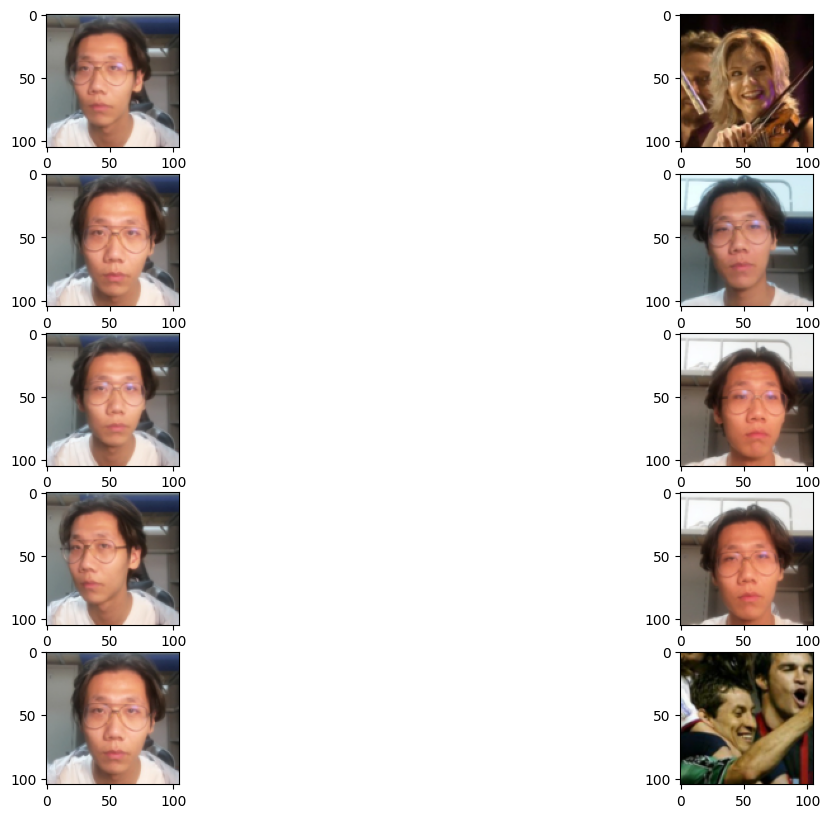

In [9]:
import matplotlib.pyplot as plt 
import torchvision
import torchvision.transforms as transforms
with torch.no_grad():
        for batch_data, batch_labels in test_dataloader:
            # 获取训练数据
            batch_anchors = batch_data[:, :3, :, :]
            batch_inputs = batch_data[:, 3:, :, :]
            
            outputs = net(batch_anchors,batch_inputs)
            for i in range(16):
                if outputs[i][0] >= 0.5:
                    outputs[i][0] = 1
                else:
                    outputs[i][0] = 0
            outputs = outputs.squeeze(1)
            outputs = outputs.long()
            print(outputs)
            print(batch_labels)
            
            image1 = check_tensor_image(batch_anchors[0])
            image2 = check_tensor_image(batch_inputs[0])
            image3 = check_tensor_image(batch_anchors[1])
            image4 = check_tensor_image(batch_inputs[1])
            image5 = check_tensor_image(batch_anchors[2])
            image6 = check_tensor_image(batch_inputs[2])
            image7 = check_tensor_image(batch_anchors[3])
            image8 = check_tensor_image(batch_inputs[3])
            image9 = check_tensor_image(batch_anchors[4])
            image10 = check_tensor_image(batch_inputs[4])
            # Set plot size 
            plt.figure(figsize=(15,10))

            # Set first subplot
            plt.subplot(5,2,1)
            plt.imshow(image1)

            # Set second subplot
            plt.subplot(5,2,2)
            plt.imshow(image2)

            plt.subplot(5,2,3)
            plt.imshow(image3)
            plt.subplot(5,2,4)
            plt.imshow(image4)
            plt.subplot(5,2,5)
            plt.imshow(image5)
            plt.subplot(5,2,6)
            plt.imshow(image6)

            plt.subplot(5,2,7)
            plt.imshow(image7)
            plt.subplot(5,2,8)
            plt.imshow(image8)
            
            plt.subplot(5,2,9)
            plt.imshow(image9)
            plt.subplot(5,2,10)
            plt.imshow(image10)
            # Renders cleanly
            plt.show()
            break

In [10]:
torch.save(net.state_dict(), 'mei.pth')
torch.save(embed1.state_dict(), 'embed1.pth')
torch.save(embed2.state_dict(), 'embed2.pth')

In [14]:
model = SiameseNN()

# 加载模型参数
model.load_state_dict(torch.load('mei.pth'))

<All keys matched successfully>

bd795034-3ac6-11ee-a043-bc542f5e9e16
D:/学习/暑假科研学习/Face_Recognition/data/input\bd795034-3ac6-11ee-a043-bc542f5e9e16.jpg


FileNotFoundError: [Errno 2] No such file or directory: 'D:/学习/暑假科研学习/Face_Recognition/data/input\\bd795034-3ac6-11ee-a043-bc542f5e9e16.jpg'